# 필수 라이브러리 설치

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
from torch.distributions import Categorical
import random

# Hyperparameters

In [ ]:
#Hyperparameters
learning_rate = 5*1e-5
gamma         = 0.99

# Grid World

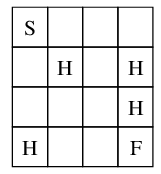

In [ ]:
# model 설정
# 4x4, state는 (x, y), H:hole, G:goal
# reward: goal:1 이며 나머지는 0
#
#     0  1  2  3
#     4  H  6  H
#     8  9 10  H
#     H 12 13  G
#
class GridWorld():
    def __init__(self):
        self.x = 0
        self.y = 0

    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a == 0:
            self.move_left()
        elif a == 1:
            self.move_down()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_up()

        if self.x == 3 and self.y == 3:
            reward = 1
        else:
            reward = 0

        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_down(self):
        self.y += 1
        if self.y > 3:
            self.y = 3

    def move_up(self):
        self.y -= 1
        if self.y < 0:
            self.y = 0

    def move_left(self):
        self.x -= 1
        if self.x < 0:
            self.x = 0

    def move_right(self):
        self.x += 1
        if self.x > 3:
            self.x = 3

    def is_done(self):
        if self.x == 3 and self.y == 3:
            return True
        elif self.x == 0 and self.y == 3:
            return True
        elif self.x == 1 and self.y == 1:
            return True
        elif self.x == 3 and self.y == 1:
            return True
        elif self.x == 3 and self.y == 2:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        # Random Initialize

        start = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (2, 1), (2, 0), (2, 1), (2, 2), (3, 1), (3, 2)]
        (self.x,self.y)=random.choice(start)
        return (self.x, self.y)

# Network

In [ ]:
def identity(x):
    """Return input without any change."""
    return x


class MLP(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 output_limit=1.0,
                 hidden_sizes=(64, 64),
                 activation=F.relu,
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
                 ):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)
            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)
        else:
            self.output_layer = identity

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x
        return x

# Train

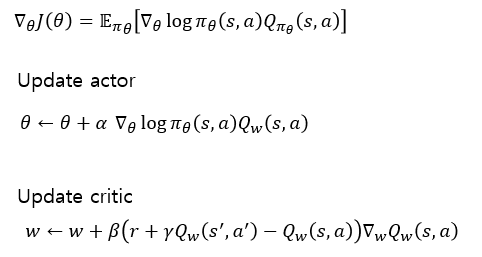

In [ ]:
def train(transition,actor,critic,optimizer_actor,optimizer_critic):
    log_pi, v, reward, next_obs, done_mask = transition

    # Prediction V(s')
    next_v = critic(torch.Tensor(next_obs))

    # Target for Q regression
    q = reward + gamma * done_mask * next_v

    # Advantage = Q - V
    advant = q - v

    # A2C losses
    policy_loss = -log_pi * advant.detach()
    vf_loss = F.mse_loss(v, q.detach())

    # Update value network parameter
    optimizer_critic.zero_grad()
    vf_loss.backward()
    optimizer_critic.step()

    # Update policy network parameter
    optimizer_actor.zero_grad()
    policy_loss.backward()
    optimizer_actor.step()

# Actor

In [ ]:
class Actor(MLP):
    def forward(self, x):
        x = super(Actor, self).forward(x)
        pi = F.softmax(x, dim=-1)

        dist = Categorical(pi)
        action = dist.sample()
        log_pi = dist.log_prob(action)
        return action, pi, log_pi

# Actor Critic

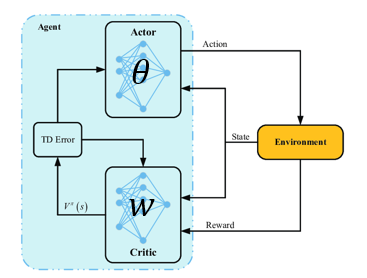

In [ ]:
def AC():
    env = GridWorld()
    actor = Actor(input_size=2,output_size=4,activation=torch.tanh)
    critic = MLP(input_size=2,output_size=1,activation=torch.tanh)

    print_interval = 100
    score = 0.0
    optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate)
    optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        done = False
        s = np.asarray(env.reset())

        while not done:

            a,pi,log_pi = actor(torch.Tensor(s))
            v=critic(torch.Tensor(s))
            a=a.item()
            (x_prime, y_prime), reward, done = env.step(a)
            s_prime =  np.array([x_prime, y_prime])
            done_mask = 0.0 if done else 1.0
            s = s_prime
            score += reward

            transition=[log_pi,v,reward,s_prime,done_mask]
            train(transition, actor, critic, optimizer_actor, optimizer_critic)


        if n_epi % 100 == 0 and n_epi != 0:
            print("n_episode :{}, score : {:.1f}".format(
                n_epi, score / print_interval))
            score = 0.0

    # print policy
    for r in range(4):
        for c in range(4):
            s = np.array([c, r])
            _,pi,_ = actor(torch.from_numpy(s).float())
            a=pi.argmax()
            if c == 3 and r == 3:
                str = 'G'
            elif c == 0 and r == 3:
                str = 'H'
            elif c == 1 and r == 1:
                str = 'H'
            elif c == 3 and r == 1:
                str = 'H'
            elif c == 3 and r == 2:
                str = 'H'
            else:
                if a == 0:
                    str = '<'
                elif a == 1:
                    str = 'v'
                elif a == 2:
                    str = '>'
                elif a == 3:
                    str = '^'
            print('%03s  '%str, end='')
        print('')

# Main

In [ ]:
if __name__ == '__main__':
    AC()